In [1]:
import sys

sys.path.insert(0, './ModelCompression')
dataset = 'mnist'
current_state = 'layer_input'
next_state = 'layer_output'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm
from utils import *
from CompressionTechniques import *
from replay_buffer import ReplayBuffer
from environments import *
from custom_layers import ROIEmbedding, ROIEmbedding1D
from reinforcement_models import DQNAgent
import sys
import gc

logging.basicConfig(level=logging.INFO, handlers=[
        logging.FileHandler('./data/ModelCompression.log')],
        # logging.StreamHandler()], 
        format='%(asctime)s -%(levelname)s - %(funcName)s -  %(message)s')

/home/A00806415/anaconda3/envs/mc/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluate agent

In [3]:
def evaluate_adadeep(env, conv_agent, fc_agent, n_games=1, greedy=True, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    acc = []
    weights = []
    infos = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        df = pd.DataFrame()
        for k in range(len(env.layer_name_list)):
          next_layer_name = env.layer_name_list[env._layer_counter]
          layer = env.model.get_layer(next_layer_name)
          was_conv = False
          random_feature = s[np.random.choice(s.shape[0], size=1)]
          if isinstance(layer, tf.keras.layers.Conv2D):
              qvalues = conv_agent.get_qvalues(random_feature).numpy()
              action = qvalues.argmax(axis=-1)[0] if greedy else conv_agent.sample_actions(qvalues)[0]
          if isinstance(layer, tf.keras.layers.Dense):
              qvalues = fc_agent.get_qvalues(random_feature).numpy()
              action = qvalues.argmax(axis=-1)[0] if greedy else fc_agent.sample_actions(qvalues)[0]

          new_s, r, done, info = env.step(action)
          s = env.get_state('current_state')
          if done:
              s = env.reset()
              break

          row = {'state': s, 'action': action, 'reward': r, 'next_state': new_s, 'done':done, 'info':info}
          df = df.append(row, ignore_index = True)

        # Calculate reward using stats before and after compression
        before_stats = df.iloc[0]['info']
        after_stats = df.iloc[-1]['info']
        reward = 1 - after_stats['weights_after']/before_stats['weights_before'] + after_stats['acc_after']

        rewards.append(reward)
        acc.append(info['acc_after'])
        weights.append(info['weights_after'])
    return np.mean(rewards), np.mean(acc), np.mean(weights)
    
def play_and_record_adadeep(conv_agent, fc_agent, env, conv_replay, fc_replay, dataset, current_state, next_state, n_steps=1, debug=False):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time
    """
    # initial state
    s = env.reset()
    # Play the game for n_steps as per instructions above
    rewards = 0
    
    for it in range(n_steps):
        df = pd.DataFrame()
        for k in range(1,len(env.layer_name_list)+1):
          tf.keras.backend.clear_session()
          
          current_layer_name = env.layer_name_list[env._layer_counter]
          layer = env.model.get_layer(current_layer_name)
          was_conv = False
          if isinstance(layer, tf.keras.layers.Conv2D):
            random_image = s[np.random.choice(s.shape[0], size=1)]
            qvalues = conv_agent.get_qvalues(random_image).numpy()
            action = conv_agent.sample_actions(qvalues)[0]
            was_conv = True
          if isinstance(layer, tf.keras.layers.Dense):
            random_image = s[np.random.choice(s.shape[0], size=1)]
            qvalues = fc_agent.get_qvalues(random_image).numpy()
            action = fc_agent.sample_actions(qvalues)[0]

          new_s, r, done, info = env.step(action)

          info['was_conv'] = was_conv

          if debug:
            print('Iteration {} - Layer {}/{}'.format(it, k, len(env.layer_name_list)), s.shape, action, r, new_s.shape, done, info)


          row = {'state': s, 'action': action, 'reward': r, 'next_state': new_s, 'done':done, 'info':info}
          df = df.append(row, ignore_index = True)

          s = env.get_state('current_state')
    
          if done:
              s = env.reset()
              break
          gc.collect()
          

        # Calculate reward using stats before and after compression
        before_stats = df.iloc[0]['info']
        after_stats = df.iloc[-1]['info']

        reward = 1 - after_stats['weights_after']/before_stats['weights_before'] + after_stats['acc_after']

        # Set the same reward for all actions.
        df['reward'] = reward
        
        for idx, row in df.iterrows():
          was_conv = row['info']['was_conv']
          if was_conv:
            for idx, feature in enumerate(row['state']):
              conv_replay.add(feature, row['action'], row['reward'], row['next_state'][idx], row['done'])
          else:
            for idx, feature in enumerate(row['state']):
              fc_replay.add(feature, row['action'], row['reward'], row['next_state'][idx], row['done'])
        
        fc_replay.save('./data/{}_adadeep_fc_replay_{}_{}.pkl'.format(dataset,current_state, next_state))
        conv_replay.save('./data/{}_adadeep_conv_replay_{}_{}.pkl'.format(dataset,current_state, next_state))
    return reward

# Create environment

In [4]:
def make_env(dataset, current_state_source='layer_input', next_state_source='layer_output'):
    train_ds, valid_ds, test_ds, input_shape, num_classes = load_dataset(dataset)

    model_path = './data/full_model/test_'+dataset
    try:
      model = tf.keras.models.load_model(model_path, compile=True)
    except OSError:
      optimizer = tf.keras.optimizers.Adam()
      loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
      train_metric = tf.keras.metrics.SparseCategoricalAccuracy()
      model = tf.keras.Sequential([tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_0',
                                                          input_shape=input_shape),
                                    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_1'),
                                    tf.keras.layers.MaxPool2D((2, 2), 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu', name='dense_0'),
                                    tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
                                    tf.keras.layers.Dense(num_classes, activation='softmax', name='dense_softmax')
                                    ])
      model.compile(optimizer=optimizer, loss=loss_object, metrics=train_metric)
      model.fit(train_ds, epochs=5, validation_data=valid_ds)
      model.save(model_path)


    w_comprs = ['InsertDenseSVD', 'InsertDenseSparse', 'DeepCompression'] # 'InsertDenseSVDCustom'
    c_comprs = ['InsertSVDConv', 'SparseConvolutionCompression','DepthwiseSeparableConvolution', 'SparseConnectionsCompression'] 
    l_comprs = ['FireLayerCompression', 'MLPCompression','ReplaceDenseWithGlobalAvgPool']
    compressors_list = w_comprs + c_comprs + l_comprs

    parameters = {}
    parameters['DeepCompression'] = {'layer_name': 'dense_0', 'threshold': 0.001}
    parameters['ReplaceDenseWithGlobalAvgPool'] = {'layer_name': 'dense_1'}
    parameters['InsertDenseSVD'] = {'layer_name': 'dense_0', 'units': 16}
    parameters['InsertDenseSVDCustom'] = {'layer_name': 'dense_0', 'units': 16}
    parameters['InsertDenseSparse'] = {'layer_name': 'dense_0', 'verbose': True, 'units': 16}
    parameters['InsertSVDConv'] = {'layer_name': 'conv2d_1', 'units': 8}
    parameters['DepthwiseSeparableConvolution'] = {'layer_name': 'conv2d_1'}
    parameters['FireLayerCompression'] = {'layer_name': 'conv2d_1'}
    parameters['MLPCompression'] = {'layer_name': 'conv2d_1'}
    parameters['SparseConvolutionCompression'] = {'layer_name': 'conv2d_1', 'bases':4}
    parameters['SparseConnectionsCompression'] = {'layer_name': 'conv2d_1', 'epochs': 20,
                                                  'target_perc': 0.75, 'conn_perc_per_epoch': 0.1}

    layer_name_list = ['conv2d_1','dense_0', 'dense_1']

    env = ModelCompressionEnv(compressors_list, model_path, parameters,
                 train_ds, valid_ds, test_ds,
                 layer_name_list, input_shape, current_state_source=current_state_source, next_state_source=next_state_source, verbose=False)
    
    return env

env = make_env(dataset, current_state, next_state)
env.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_0 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_0 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                1

# Create DQN for model compression


In [5]:
fc_state_dim = (1,)
fc_n_actions = len(env.dense_compressors)
conv_state_dim = list(env.get_state('current_state').shape)[1:]
print(conv_state_dim)
conv_n_actions = len(env.conv_compressors)

fc_agent = DQNAgent("dqn_agent_fc", fc_state_dim, fc_n_actions, epsilon=0.9, layer_type='fc')
fc_target_network = DQNAgent("target_network_fc", fc_state_dim, fc_n_actions, layer_type='fc')


conv_agent = DQNAgent("dqn_agent_conv", conv_state_dim, conv_n_actions, epsilon=0.9, layer_type='cnn')
conv_target_network = DQNAgent("target_network_conv", conv_state_dim, conv_n_actions, layer_type='cnn')

def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    for i in range(len(agent.model.layers)):
        target_network.model.layers[i].set_weights(agent.model.layers[i].get_weights())


load_weigths_into_target_network(fc_agent, fc_target_network)
load_weigths_into_target_network(conv_agent, conv_target_network)

for w, w2 in zip(fc_agent.weights, fc_target_network.weights):
    tf.assert_equal(w, w2)
for w, w2 in zip(conv_agent.weights, conv_target_network.weights):
    tf.assert_equal(w, w2)

print("It works!")

[26, 26, 32]
Model: "dqn_agent_fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
roi_embedding1d (ROIEmbeddin (None, 63)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               32768     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 34,820
Trainable params: 34,820
Non-trainable params: 0
_________________________________________________________________
Model: "target_network_fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 1)]         0         
__________

# Training func


In [6]:
def moving_average(x, span=100, **kw):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values


mean_weights_history = []
mean_acc_history = []
mean_rw_history = []
td_loss_history_conv = []
td_loss_history_fc = []




def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        'state': obs_batch,
        'action': act_batch,
        'rewards': reward_batch,
        'next_state': next_obs_batch,
        'done': is_done_batch,
    }


#@tf.function
def training_loop(state, action, rewards, next_state, done, agent, target_agent, loss_optimizer, n_actions, gamma=0.01):
    state = tf.cast(state, tf.float32)
    action = tf.cast(action, tf.int32)
    next_state = tf.cast(next_state, tf.float32)

    rewards = tf.cast(rewards, tf.float32)
    done = 1 - tf.cast(done, tf.float32)

    reference_qvalues = rewards + gamma * tf.reduce_max(target_agent.get_qvalues(next_state), axis=1)
    reference_qvalues = reference_qvalues * (1 - done) - done

    masks = tf.one_hot(action, n_actions)
    with tf.GradientTape() as tape:
        q_values = agent.get_qvalues(state)
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        td_loss = tf.reduce_mean((q_action - reference_qvalues) ** 2)

    gradients = tape.gradient(td_loss, agent.weights)
    loss_optimizer.apply_gradients(zip(gradients, agent.weights))
    return td_loss



# Generate some replay buffer samples

In [7]:

fc_agent.epsilon = 0.5
conv_agent.epsilon = 0.5
min_epsilon = 0.1
optimizer = tf.keras.optimizers.Adam(1e-5)
iterations = 1000

fc_exp_replay = ReplayBuffer(10 ** 5)
conv_exp_replay = ReplayBuffer(10 ** 5)

try:
  fc_exp_replay.load('./data/{}_adadeep_fc_replay_{}_{}.pkl'.format(dataset,current_state, next_state))
  conv_exp_replay.load('./data/{}_adadeep_conv_replay_{}_{}.pkl'.format(dataset,current_state, next_state))
except FileNotFoundError:
  pass

print('There are {} conv and {} fc instances.'.format(len(conv_exp_replay),len(fc_exp_replay)))
play_and_record_adadeep(conv_agent, fc_agent, env, conv_exp_replay, fc_exp_replay, dataset, current_state, next_state, 1, debug=True)

print('There are {} conv and {} fc instances.'.format(len(conv_exp_replay),len(fc_exp_replay)))

There are 0 conv and 0 fc instances.
Iteration 0 - Layer 1/3 (12000, 26, 26, 32) 4 0.9888092191215135 (12000, 26, 26, 32) False {'was_conv': True, 'acc_before': 0.9872499704360962, 'acc_after': 0.982200026512146, 'weights_before': 617322, 'weights_after': 613242}
Iteration 0 - Layer 2/3 (12000, 4608) 2 1.8225465823344833 (12000, 4608) False {'was_conv': False, 'acc_before': 0.982200026512146, 'acc_after': 0.9843000173568726, 'weights_before': 613242, 'weights_after': 99194}
Iteration 0 - Layer 3/3 (12000, 4608) 1 0.9852174115541023 (12000, 4608) True {'was_conv': False, 'acc_before': 0.9843000173568726, 'acc_after': 0.9843000173568726, 'weights_before': 99194, 'weights_after': 99103}
There are 12000 conv and 24000 fc instances.


# RFL Training

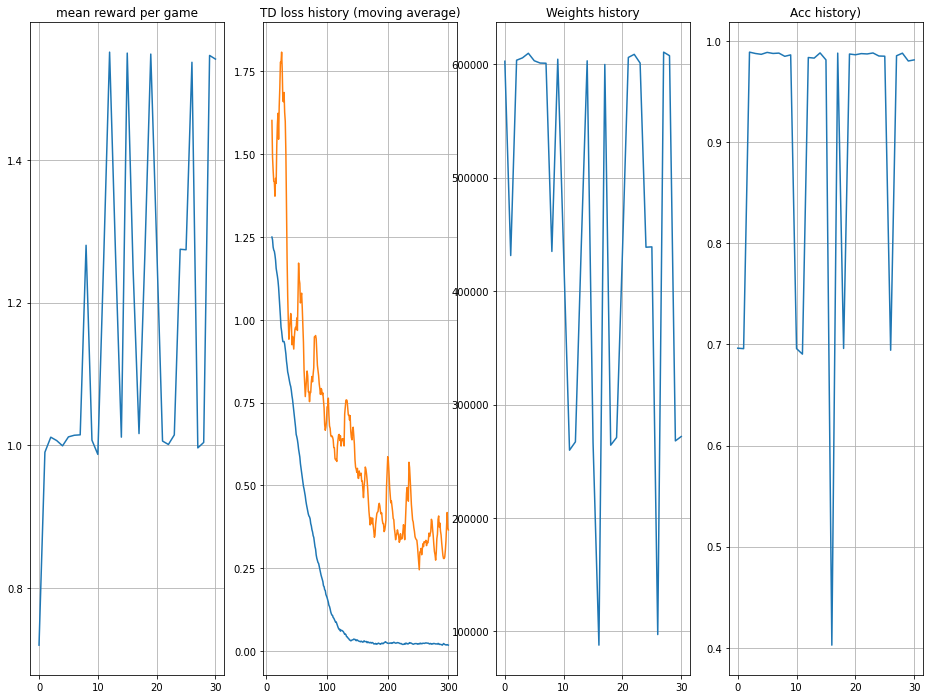

 30%|███       |304/1000 [30:34:01<69:58:57, 361.98s/it, Epsilon: 0.2673 Last 3 RW: 1.00, 1.55 & 1.54 W: 607370.00, 267961.67 & 271818.00 Acc: 0.99, 0.98 & 0.98] 


KeyboardInterrupt: 

In [8]:
with tqdm(total=iterations,
          bar_format="{l_bar}{bar}|{n}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}, Epsilon: {postfix[0]:.4f} Last 3 RW: {postfix[1][0]:.2f}, {postfix[1][1]:.2f} & {postfix[1][2]:.2f} W: {postfix[2][0]:.2f}, {postfix[2][1]:.2f} & {postfix[2][2]:.2f} Acc: {postfix[3][0]:.2f}, {postfix[3][1]:.2f} & {postfix[3][2]:.2f}]",
          postfix=[conv_agent.epsilon, dict({0:0,1:0,2:0}), dict({0:0,1:0,2:0}), dict({0:0,1:0,2:0})]) as t:
    for i in range(iterations):
        # play
        play_and_record_adadeep(conv_agent, fc_agent, env, conv_exp_replay, fc_exp_replay, dataset, current_state, next_state, 1, debug=False)

        # train fc
        batch_data = sample_batch(conv_exp_replay, batch_size=32)
        batch_data['agent'] = conv_agent
        batch_data['target_agent'] = conv_target_network
        batch_data['loss_optimizer'] = optimizer
        batch_data['n_actions'] = conv_n_actions
        conv_loss_t = training_loop(**batch_data)
        td_loss_history_conv.append(conv_loss_t)

        # train
        batch_data = sample_batch(fc_exp_replay, batch_size=32)
        batch_data['agent'] = fc_agent
        batch_data['target_agent'] = fc_target_network
        batch_data['loss_optimizer'] = optimizer
        batch_data['n_actions'] = fc_n_actions
        fc_loss_t = training_loop(**batch_data)
        td_loss_history_fc.append(fc_loss_t)

        # adjust agent parameters
        if i % 10 == 0:
            load_weigths_into_target_network(conv_agent, conv_target_network)
            conv_target_network.model.save_weights('./checkpoints/{}_my_checkpoint_conv'.format(dataset))
            conv_agent.epsilon = max(conv_agent.epsilon * 0.98, min_epsilon)
            t.postfix[0] = conv_agent.epsilon

            load_weigths_into_target_network(fc_agent, fc_target_network)
            fc_target_network.model.save_weights('./checkpoints/{}_my_checkpoint_fc'.format(dataset))
            fc_agent.epsilon = conv_agent.epsilon

            rw, acc, weights = evaluate_adadeep(make_env(dataset), conv_agent, fc_agent, n_games=3)
            mean_rw_history.append(rw)
            mean_acc_history.append(acc)
            mean_weights_history.append(weights)
            t.postfix[1][2] = mean_rw_history[-1]
            try:
                t.postfix[1][1] = mean_rw_history[-2]
            except IndexError:
                t.postfix[1][1] = 0
            try:
                t.postfix[1][0] = mean_rw_history[-3]
            except IndexError:
                t.postfix[1][0] = 0
            
            t.postfix[2][2] = mean_weights_history[-1]
            try:
                t.postfix[2][1] = mean_weights_history[-2]
            except IndexError:
                t.postfix[2][1] = 0
            try:
                t.postfix[2][0] = mean_weights_history[-3]
            except IndexError:
                t.postfix[2][0] = 0

            t.postfix[3][2] = mean_acc_history[-1]
            try:
                t.postfix[3][1] = mean_acc_history[-2]
            except IndexError:
                t.postfix[3][1] = 0
            try:
                t.postfix[3][0] = mean_acc_history[-3]
            except IndexError:
                t.postfix[3][0] = 0
        t.update()


        if i%10==0:
            clear_output(True)
            plt.figure(figsize=(16, 12))
            plt.subplot(1, 4, 1)
            plt.title("mean reward per game")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history_fc).any() and not np.isnan(td_loss_history_conv).any() 

            plt.subplot(1, 4, 2)
            plt.title("TD loss history (moving average)")
            plt.plot(moving_average(np.array(td_loss_history_conv), span=10, min_periods=10))
            plt.plot(moving_average(np.array(td_loss_history_fc), span=10, min_periods=10))
            plt.grid()

            plt.subplot(1, 4, 3)
            plt.title("Weights history")
            plt.plot(mean_weights_history)
            plt.grid()

            plt.subplot(1, 4, 4)
            plt.title("Acc history)")
            plt.plot(mean_acc_history)
            plt.grid()
            plt.show()